There could be erros, mistakes

In [1]:
import random
from math import exp, log, sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Simulating value of covered-call portfolio over specific periods

In [2]:
def get_data(ticker, periods='1y', rename=None, only_price=False):
  """
  ticker : Object of yf.Ticker
  periods : Data periods
  rename : List of new column names are required if renaming is necessary
  only_price :Getting only price data if other data is not essential
  """
  columns = ['Close'] if only_price == True else ['Close','Volume']
  ticker_hist = ticker.history(period=periods)
  ticker_hist = ticker_hist[columns]
  rename = ['price'] if ((rename == None) and (only_price == True)) else rename
  ticker_hist.columns = rename
  ticker_hist = ticker_hist.reset_index()
  ticker_hist['Date'] = pd.to_datetime(ticker_hist['Date']).dt.strftime('%Y-%m-%d')
  return ticker_hist

In [3]:
def scaler(df):
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
  return scaled_df

In [4]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    call_price = S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    return call_price

In [17]:
def covered_call_value(start_b, start_s, days, M, s_v, threshold, fee):
  """
  c_prm : Call option premium
  b : Latest portfolio value
  s : Latest spot price
  x : Latest strike price
  b_lst : List of portfolio values
  s_lst : List of spot prices
  x_lst : List of strike prices
  """
  c_prm = black_scholes_call(start_s, start_s*(1.05), days, 0.02, s_v)
  b = (start_b - start_s) + c_prm + start_s
  s = start_s
  x = start_s*(1.05)
  b_lst = []
  s_lst = []
  x_lst = []

  b_lst.append(b)
  s_lst.append(s)
  x_lst.append(x)
  for j in range(M):
    rnd_lst = [random.random() for _ in range(days)]
    print(f"{j} month")
    for i in range(days):
      if rnd_lst[i] >= threshold:
        s = s + (s*s_v)
      else:
        s = s - (s*s_v)
      print(f"day {i} price is {s}")
      # s_lst.append(round(s,4))
    s_lst.append(round(s,4))
    x = round(s+(s*0.05),4) # calculate new strike price of new call option for next 30days
    x_lst.append(x)
    # c_prm = black_scholes_call(s_lst[-1], x_lst[-1], days, 0.02, s_v) # calculate new premium of new call option, whose strike price is updated.
    c_prm = round(5 + max(x_lst[-1] - s_lst[-1], 0),4)
    if s_lst[-1] <= x_lst[j]: # otm
      b = b_lst[j] + (s_lst[-1]-s_lst[j]) + c_prm
      b_lst.append(b)
    else: # itm
      borrow = abs(b_lst[j] - s_lst[-1])
      b = c_prm - borrow
      b_lst.append(b)
    print(f"s : {s_lst[-1]} and x : {x_lst[-1]} and x/s = {round(x_lst[-1]/s_lst[-1],4)} and x-s = {round(x_lst[-1] - s_lst[-1],4)}, c_prm : {c_prm}, pf-value : {b_lst[-1]}")
  return (b_lst, s_lst, x_lst)

Simulation down below shows the value of covered-call portfolio. Probability of stock(=spot) price goes down is little bit higher, which means there are merely downward trend in the market. I assumed covered-call portfolio is rebalanced at the end of maturity by repositioning(buy stock sell call option if call option buyer exercises right, otherwise just keeping stock and selling call option). However since person who owns coverd-call portfolio roll its position, this assumption might unrealistic. Reason for this unrealistic assumption is, i just watnted to visualize very simple(very beginner level) covered-call portfolio.

In [ ]:
# options are assumed only for call option
current_b = 100 # current port value
current_s = 100
s_v = 0.005 # stock price volatility. Unlike real world, it is constant for my simulation.
days = 30 # i assumed there are 30 days per month.
M = 36 # month
pf_value_lst = []
sp_price_lst = []
threshold = 0.51 # controls tendency of stock movement. If threshold is less than 0.5 then, it implies there are more liklihood for stock price move upward.
fee = 0.009
b_lst1, s_lst1, x_lst1 = covered_call_value(current_b, current_s, days, M, s_v, threshold,fee)


It might unusual to see covered call portfolio value decreases when stock price goes up. However since i assumed buying stock to reposition even if stock price sky rocketed, portfoilio needs to loan money to purchase expensive stock(reason why  portfollio value.can be negative).

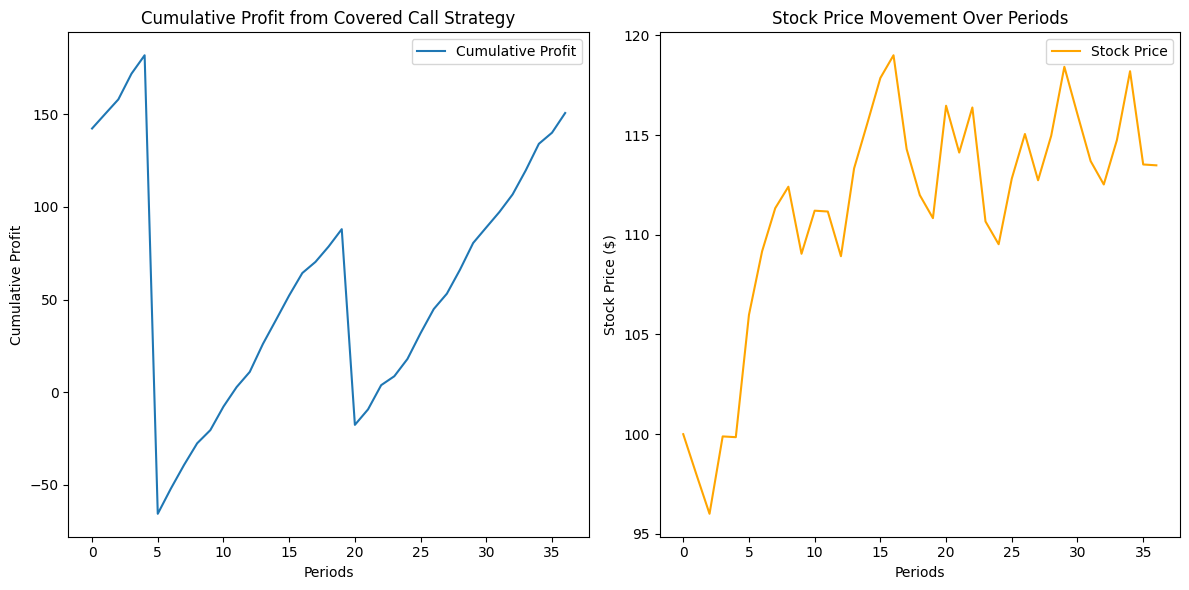

In [19]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(b_lst1, label="Cumulative Profit")
plt.xlabel("Periods")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit from Covered Call Strategy")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(s_lst1, label="Stock Price", color="orange")
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

# Movement between CONY ETF and Coinbase stock price and Bitcoin price.

In [ ]:
cony = yf.Ticker("CONY")
coin = yf.Ticker("COIN")
bit = yf.Ticker('BTC-USD')

cony_hist = get_data(cony, rename=['cony_price','cony_volume'])
coin_hist = get_data(coin, rename=['coin_price','coin_volume'])
bit_hist = get_data(bit, rename=['bit_price','bit_volume'])

df_cc = cony_hist.merge(coin_hist, on='Date', how='outer')
df = df_cc.merge(bit_hist, on='Date', how='outer')
df = df.dropna()
df = df.reset_index().drop(columns=['index'])
df

since bitcoin price's unit is different compare to coinbase stock price and cony price, let's normalize each values.

<Axes: >

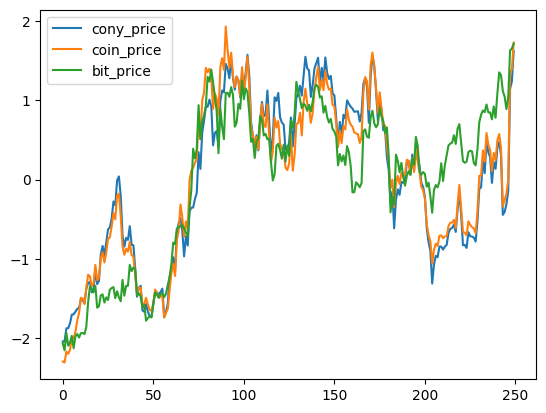

In [9]:
price_df = df[['cony_price','coin_price','bit_price']]
scaled_price_df = scaler(price_df)
scaled_price_df.plot()

In [10]:
# let's see correlations
price_df_corr_mat = price_df.corr()
price_df_corr_mat

,cony_price,coin_price,bit_price
cony_price,1.000000,0.979376,0.835921
coin_price,0.979376,1.000000,0.877223
bit_price,0.835921,0.877223,1.000000


# Comparisons of other notable high yield covered call etf TSLY NVDY with their base asset(TSLA NVDA each)

In [11]:
tsly = yf.Ticker("TSLY")
tsla = yf.Ticker("TSLA")
nvdy = yf.Ticker("NVDY")
nvda = yf.Ticker("NVDA")

tsly_hist = get_data(tsly, periods='6mo', rename=['tsly_price'], only_price=True)
tsla_hist = get_data(tsla, periods='6mo', rename=['tsla_price'], only_price=True)
nvdy_hist = get_data(nvdy, periods='6mo', rename=['nvdy_price'], only_price=True)
nvda_hist = get_data(nvda, periods='6mo', rename=['nvda_price'], only_price=True)

df_ts = tsly_hist.merge(tsla_hist, on='Date', how='outer')
df_nv = nvdy_hist.merge(nvda_hist, on='Date', how='outer')
# df_ts

In [12]:
scaled_ts_df = scaler(df_ts[['tsly_price','tsla_price']])
scaled_nv_df = scaler(df_nv[['nvdy_price','nvda_price']])

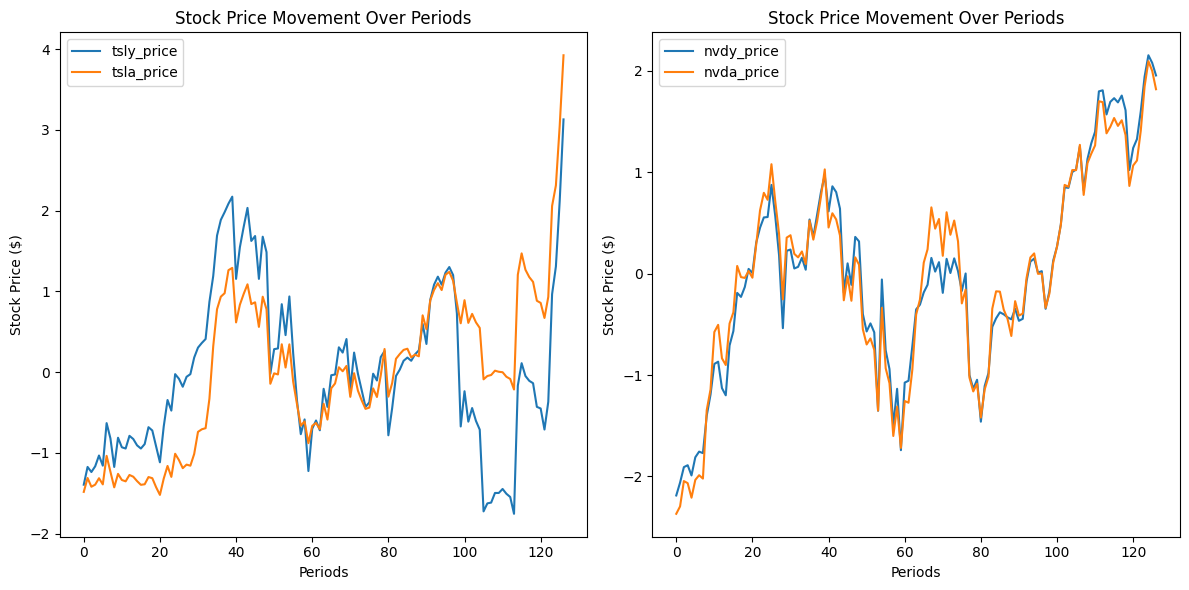

In [13]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(scaled_ts_df, label=['tsly_price','tsla_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(scaled_nv_df, label=['nvdy_price','nvda_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
df_ts_corr_mat = scaled_ts_df.corr()
df_nv_corr_mat = scaled_nv_df.corr()

In [15]:
df_ts_corr_mat

,tsly_price,tsla_price
tsly_price,1.000000,0.690971
tsla_price,0.690971,1.000000


In [16]:
df_nv_corr_mat

,nvdy_price,nvda_price
nvdy_price,1.000000,0.982529
nvda_price,0.982529,1.000000
